In [15]:
# https://www.youtube.com/watch?v=zxD-v3ve-bk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import splitfolders
import os

In [16]:
splitfolders.ratio(
    "data", output="data_split", seed=42, ratio=(0.8, 0.1, 0.1)
)  # default values

In [17]:
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
    ]
)

In [18]:
train_data = datasets.ImageFolder(
    root=os.path.join("data_split", "train"), transform=transform
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

val_data = datasets.ImageFolder(
    root=os.path.join("data_split", "val"), transform=transform
)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True)

In [19]:
print(train_data)

Dataset ImageFolder
    Number of datapoints: 202
    Root location: data_split/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


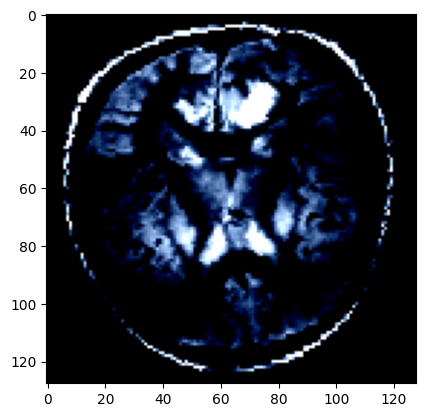

In [20]:
img, label = train_data[100]
plt.imshow(img.permute(1, 2, 0))

In [21]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.5)  # Add dropout for uncertainty estimation
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.pool1(self.leaky_relu(self.conv1(x)))
        x = self.pool2(self.leaky_relu(self.conv2(x)))
        x = self.pool3(self.leaky_relu(self.conv3(x)))
        x = self.pool4(self.leaky_relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)  # Apply dropout
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x


In [22]:
writer = SummaryWriter("logs")

In [23]:
num_epochs = 30
model = CNNModel(num_classes=len(train_data.classes))
error = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

In [24]:
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        writer.add_scalar("Loss/Train", loss.item(), epoch * len(train_loader) + i)

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)

    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = error(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / len(val_loader)
    val_loss_list.append(val_loss)
    writer.add_scalar("Validation/Train", val_loss, epoch)
    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    writer.add_scalar("Accuracy/Train", accuracy, epoch)

    scheduler.step(val_loss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%"
    )

print("Finished Training")
writer.close()

Epoch [1/30], Train Loss: 0.7841, Val Loss: 0.6899, Accuracy: 62.50%
Epoch [2/30], Train Loss: 0.6896, Val Loss: 0.5729, Accuracy: 79.17%
Epoch [2/30], Train Loss: 0.6896, Val Loss: 0.5729, Accuracy: 79.17%
Epoch [3/30], Train Loss: 0.6880, Val Loss: 0.6624, Accuracy: 62.50%
Epoch [3/30], Train Loss: 0.6880, Val Loss: 0.6624, Accuracy: 62.50%
Epoch [4/30], Train Loss: 0.6849, Val Loss: 0.6299, Accuracy: 62.50%
Epoch [4/30], Train Loss: 0.6849, Val Loss: 0.6299, Accuracy: 62.50%
Epoch [5/30], Train Loss: 0.6450, Val Loss: 0.6457, Accuracy: 75.00%
Epoch [5/30], Train Loss: 0.6450, Val Loss: 0.6457, Accuracy: 75.00%
Epoch [6/30], Train Loss: 0.6652, Val Loss: 0.6744, Accuracy: 62.50%
Epoch [6/30], Train Loss: 0.6652, Val Loss: 0.6744, Accuracy: 62.50%
Epoch [7/30], Train Loss: 0.6609, Val Loss: 0.5983, Accuracy: 75.00%
Epoch [7/30], Train Loss: 0.6609, Val Loss: 0.5983, Accuracy: 75.00%
Epoch [8/30], Train Loss: 0.6852, Val Loss: 0.6543, Accuracy: 62.50%
Epoch [8/30], Train Loss: 0.6852, 

In [25]:
# Testing the model on test data
test_data = datasets.ImageFolder(
    root=os.path.join("data_split", "test"), transform=transform
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)

model.eval()
test_running_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = error(outputs, labels)
        test_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss = test_running_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.3768, Test Accuracy: 81.48%


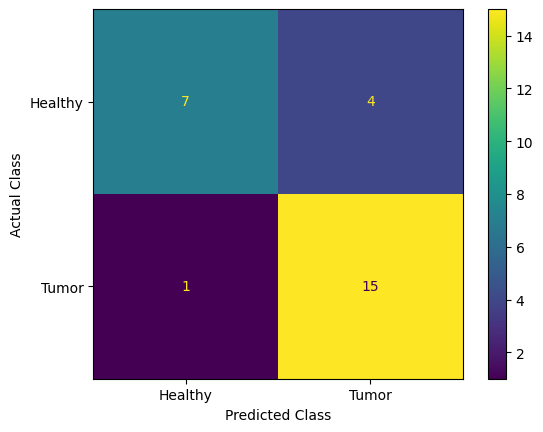

In [26]:
from sklearn import metrics

classes = ("Tumor", "Healthy")
y_pred = []
y_true = []

for inputs, labels in test_loader:
    output = model(inputs)  # Feed Network

    _, predicted = torch.max(output.data, 1)
    y_pred.extend(predicted)  # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)  # Save Truth

# Build confusion matrix
cf_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cf_matrix, display_labels=["Healthy", "Tumor"]
)

cm_display.plot()
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [27]:
from sklearn.preprocessing import LabelEncoder
import cv2


def load_images(folder, size=(128, 128)):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if not os.path.isdir(label_folder):
            continue
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, size)
                images.append(img.flatten())
                labels.append(label)
    return np.array(images), np.array(labels)


X_train, y_train = load_images("data_split/train")
X_test, y_test = load_images("data_split/test")

# Min-Max Scaling
X_train = X_train / 255.0
X_test = X_test / 255.0


le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
print("Accuracy:", metrics.accuracy_score(y_test_enc, y_pred))
print(metrics.classification_report(y_test_enc, y_pred, target_names=le.classes_))

Accuracy: 0.8148148148148148
              precision    recall  f1-score   support

          no       0.88      0.64      0.74        11
         yes       0.79      0.94      0.86        16

    accuracy                           0.81        27
   macro avg       0.83      0.79      0.80        27
weighted avg       0.82      0.81      0.81        27



Performing Uncertainty Estimation with Monte Carlo Dropout...

Accuracy: 0.8148

UNCERTAINTY ANALYSIS
Mean Uncertainty: 0.0540
Std Uncertainty: 0.0282
Min Uncertainty: 0.0105
Max Uncertainty: 0.1287

Mean Confidence: 0.7747
Std Confidence: 0.1367

Correct Predictions (n=22):
  Mean Uncertainty: 0.0505
  Mean Confidence: 0.7928

Incorrect Predictions (n=5):
  Mean Uncertainty: 0.0691
  Mean Confidence: 0.6949

Accuracy: 0.8148

UNCERTAINTY ANALYSIS
Mean Uncertainty: 0.0540
Std Uncertainty: 0.0282
Min Uncertainty: 0.0105
Max Uncertainty: 0.1287

Mean Confidence: 0.7747
Std Confidence: 0.1367

Correct Predictions (n=22):
  Mean Uncertainty: 0.0505
  Mean Confidence: 0.7928

Incorrect Predictions (n=5):
  Mean Uncertainty: 0.0691
  Mean Confidence: 0.6949


/tmp/ipykernel_25885/3869157392.py:137: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(data_to_plot, labels=labels_box)


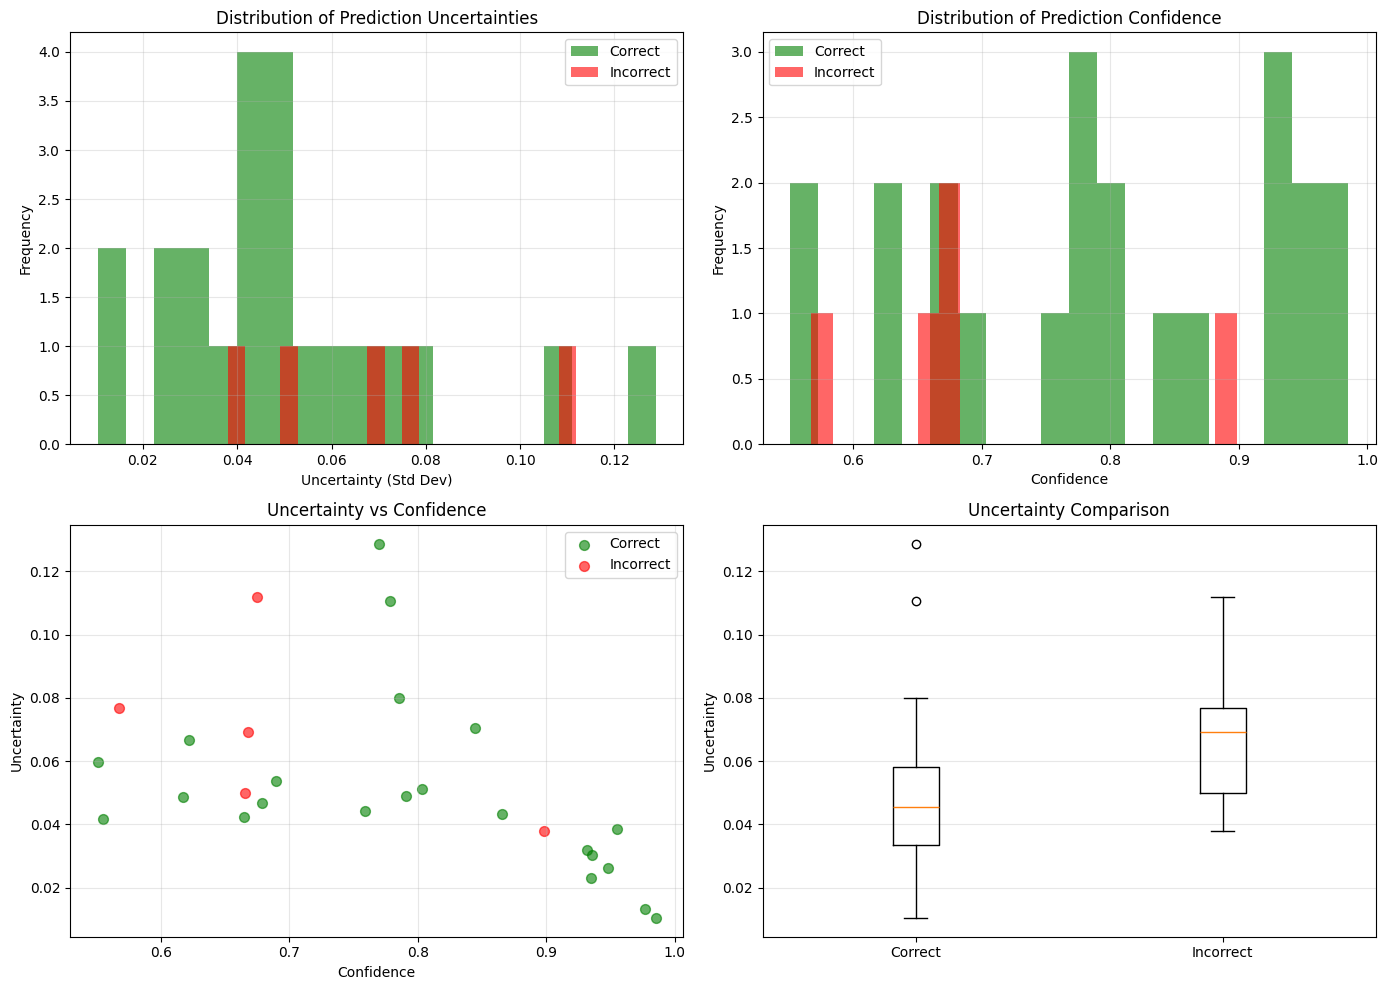


HIGH UNCERTAINTY SAMPLES (Top 5)
1. Sample 9: Uncertainty=0.1287, Confidence=0.7695 ✓
   True: Healthy, Predicted: Healthy
2. Sample 1: Uncertainty=0.1118, Confidence=0.6750 ✗
   True: Healthy, Predicted: Tumor
3. Sample 10: Uncertainty=0.1104, Confidence=0.7780 ✓
   True: Healthy, Predicted: Healthy
4. Sample 25: Uncertainty=0.0801, Confidence=0.7857 ✓
   True: Tumor, Predicted: Tumor
5. Sample 3: Uncertainty=0.0767, Confidence=0.5673 ✗
   True: Healthy, Predicted: Tumor


In [28]:
# Uncertainty Estimation using Monte Carlo Dropout
print("Performing Uncertainty Estimation with Monte Carlo Dropout...")

def estimate_uncertainty(model, test_loader, num_passes=10):
    """
    Estimate model uncertainty using Monte Carlo Dropout
    Performs multiple forward passes with dropout enabled to get uncertainty estimates
    """
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_uncertainties = []
    all_confidences = []
    
    for images, labels in test_loader:
        # Multiple forward passes with dropout enabled
        predictions_list = []
        
        for _ in range(num_passes):
            # Temporarily enable dropout even in eval mode
            for module in model.modules():
                if isinstance(module, torch.nn.Dropout):
                    module.train()
            
            with torch.no_grad():
                output = model(images)
                probs = F.softmax(output, dim=1)
                predictions_list.append(probs.cpu().numpy())
        
        # Convert back to eval mode
        model.eval()
        
        # Stack predictions: [num_passes, batch_size, num_classes]
        predictions_array = np.array(predictions_list)
        
        # Calculate mean and std of predictions
        mean_preds = predictions_array.mean(axis=0)  # [batch_size, num_classes]
        std_preds = predictions_array.std(axis=0)     # [batch_size, num_classes]
        
        # Get predicted classes and confidence
        predicted_classes = mean_preds.argmax(axis=1)
        confidence = mean_preds.max(axis=1)
        
        # Uncertainty = standard deviation of predicted class
        uncertainty = std_preds[np.arange(len(predicted_classes)), predicted_classes]
        
        all_predictions.append(predicted_classes)
        all_labels.append(labels.numpy())
        all_uncertainties.append(uncertainty)
        all_confidences.append(confidence)
    
    predictions = np.concatenate(all_predictions)
    labels = np.concatenate(all_labels)
    uncertainties = np.concatenate(all_uncertainties)
    confidences = np.concatenate(all_confidences)
    
    return predictions, labels, uncertainties, confidences


# Run uncertainty estimation
predictions_mc, true_labels_mc, uncertainties_mc, confidences_mc = estimate_uncertainty(model, test_loader, num_passes=10)

# Calculate accuracy
accuracy_mc = np.mean(predictions_mc == true_labels_mc)
print(f"\nAccuracy: {accuracy_mc:.4f}")

# Analyze by confidence
print("\n" + "="*60)
print("UNCERTAINTY ANALYSIS")
print("="*60)

print(f"Mean Uncertainty: {uncertainties_mc.mean():.4f}")
print(f"Std Uncertainty: {uncertainties_mc.std():.4f}")
print(f"Min Uncertainty: {uncertainties_mc.min():.4f}")
print(f"Max Uncertainty: {uncertainties_mc.max():.4f}")

print(f"\nMean Confidence: {confidences_mc.mean():.4f}")
print(f"Std Confidence: {confidences_mc.std():.4f}")

# Separate by correct/incorrect predictions
correct_mask = predictions_mc == true_labels_mc
correct_uncertainties = uncertainties_mc[correct_mask]
incorrect_uncertainties = uncertainties_mc[~correct_mask]

print(f"\nCorrect Predictions (n={len(correct_uncertainties)}):")
print(f"  Mean Uncertainty: {correct_uncertainties.mean():.4f}")
print(f"  Mean Confidence: {confidences_mc[correct_mask].mean():.4f}")

if len(incorrect_uncertainties) > 0:
    print(f"\nIncorrect Predictions (n={len(incorrect_uncertainties)}):")
    print(f"  Mean Uncertainty: {incorrect_uncertainties.mean():.4f}")
    print(f"  Mean Confidence: {confidences_mc[~correct_mask].mean():.4f}")
else:
    print(f"\nNo incorrect predictions!")

# Visualize uncertainty distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram of uncertainties
axes[0, 0].hist(correct_uncertainties, bins=20, alpha=0.6, label="Correct", color='green')
if len(incorrect_uncertainties) > 0:
    axes[0, 0].hist(incorrect_uncertainties, bins=20, alpha=0.6, label="Incorrect", color='red')
axes[0, 0].set_xlabel("Uncertainty (Std Dev)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Distribution of Prediction Uncertainties")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Histogram of confidences
axes[0, 1].hist(confidences_mc[correct_mask], bins=20, alpha=0.6, label="Correct", color='green')
if len(incorrect_uncertainties) > 0:
    axes[0, 1].hist(confidences_mc[~correct_mask], bins=20, alpha=0.6, label="Incorrect", color='red')
axes[0, 1].set_xlabel("Confidence")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Distribution of Prediction Confidence")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter: uncertainty vs confidence
axes[1, 0].scatter(confidences_mc[correct_mask], correct_uncertainties, alpha=0.6, label="Correct", color='green', s=50)
if len(incorrect_uncertainties) > 0:
    axes[1, 0].scatter(confidences_mc[~correct_mask], incorrect_uncertainties, alpha=0.6, label="Incorrect", color='red', s=50)
axes[1, 0].set_xlabel("Confidence")
axes[1, 0].set_ylabel("Uncertainty")
axes[1, 0].set_title("Uncertainty vs Confidence")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Box plot comparison
data_to_plot = [correct_uncertainties]
labels_box = ["Correct"]
if len(incorrect_uncertainties) > 0:
    data_to_plot.append(incorrect_uncertainties)
    labels_box.append("Incorrect")

axes[1, 1].boxplot(data_to_plot, labels=labels_box)
axes[1, 1].set_ylabel("Uncertainty")
axes[1, 1].set_title("Uncertainty Comparison")
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Find high uncertainty samples
print("\n" + "="*60)
print("HIGH UNCERTAINTY SAMPLES (Top 5)")
print("="*60)

top_uncertain_indices = np.argsort(uncertainties_mc)[-5:][::-1]
class_names = {0: "Healthy", 1: "Tumor"}

for rank, idx in enumerate(top_uncertain_indices, 1):
    true_label = true_labels_mc[idx]
    pred_label = predictions_mc[idx]
    uncertainty = uncertainties_mc[idx]
    confidence = confidences_mc[idx]
    is_correct = "✓" if true_label == pred_label else "✗"
    
    print(f"{rank}. Sample {idx}: Uncertainty={uncertainty:.4f}, Confidence={confidence:.4f} {is_correct}")
    print(f"   True: {class_names[true_label]}, Predicted: {class_names[pred_label]}")
